# Blog Post Clustering

*by Dominic Reichl (@domreichl)*

October 2018

## Introduction

My blog (https://www.mindcoolness.com) currently has 322 blog posts, which I have categorized into four broad topics:
- Psychology & Cognitive Science
- Willpower & Self-Improvement
- Philosophy & Spirituality
- Morality & Ethics

Recently, I experienced a curious desire to find out how unsupervised NLP models would cluster my writings, so I've created this notebook.

## Overview
1. Modules & Data
2. Word Vectorization
3. Word Frequency
4. Clustering (KMeans)
5. Cluster Visualization (MDS, TSNE)
6. Cluster Exploration
7. Predictive Evaluation
8. More Models (NMF, LSA, LDA)
9. Qualitative Evaluation
10. Autoencoder
11. Quantitative Evaluation
12. Conclusion

# 1. Modules & Data

This notebook requires the libraries Pandas, Beautiful Soup 4, Matplotlib, Mpld3, Scikit-learn, and TensorFlow.

With the blog post data already exported from my MySQL sever in CSV format, all we have to do here is load the CSV file into a Pandas DataFrame, filter the data, and convert the HTML code into text via BeautifulSoup.

In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS, TSNE
import mpld3
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
import tensorflow as tf
from sklearn.metrics import silhouette_score, calinski_harabaz_score

# load data
data = pd.read_csv('wp_posts.csv', sep=';')

# filter data (exclude pages, drafts, revisions, etc.), then keep only title & content
data = data[(data['post_type'] == 'post') & (data['post_status'] == 'publish')]
data = data[['post_title', 'post_content']].reset_index(drop=True)

# convert html code into text, then lowercase all words
for i in data.index:
    soup = BeautifulSoup(data['post_content'].loc[i], 'html.parser')
    data['post_content'].loc[i] = soup.get_text().lower()
    data['post_title'].loc[i] = data['post_title'].loc[i].lower()

# display the last five blog posts
data.tail()

,post_title,post_content
317,how the brain makes emotions,here's the latest state of the art in the cogn...
318,is willpower a cognitive strength?,\nwillpower is the ability to pursue long-term...
319,6 reasons why people use moral language,"\nwhy do we use moral language?\nhello, i'm do..."
320,the bayesian brain: placebo effects explained,"\n\nin my article on predictive processing, i ..."
321,"great minds discuss ideas, great men also disc...",\non great minds and great men\ngreat minds di...


# 2. Word Vectorization

Natural language processing requires all words to be represented as numbers. For our purposes, the best way to achieve this is with Scikit-learn's TfidVectorizer. This tool not only transforms words into vectors, but also ensures that the terms defining a cluster provide enough differentiation.

How does is work?

Consider first that the frequency of words like 'the', 'a', 'is', and 'and' is likely to be high in any English corpus, which means that they're of little value for document clustering. Moreover, basically every AI-related document would have the same topic if 'network', 'model', and 'algorithm' were cluster-defining terms.

A clustering algorithm will produce much better results if the term frequency (tf = how often a word appears in a document) is multiplied by the inverse document frequency (idf = a measure of how much information the word provides). This is precisely what the TfidVectorizer does when it penalizes high-frequency terms for lacking informational value.

The CountVectorizer, by contrast, uses a simple bag-of-words approach where each term is transformed into a vector based on its count/frequency. This is useful for plotting the top 20 words in our data, and it's also needed for Latent Dirichlet Allocation (LDA), a structured probabilistic model.

Lastly, we should set a lower bound on document frequency (min_df), which sets a cut-off threshold (0.05) to ignore the rarest words in our vocabulary. This will also prove useful for the autoencoder later because it speeds up the neural network training quite a lot.

In [2]:
# tf-idf (term frequency-inverse document frequency)
tfidf_vectorizer = TfidfVectorizer(stop_words='english', min_df = 0.05)
tfidf_matrix = tfidf_vectorizer.fit_transform(data['post_content'])
tfidf_words = tfidf_vectorizer.get_feature_names()

# bag of words (term frequency)
tf_vectorizer = CountVectorizer(stop_words='english', min_df = 0.05)
tf_matrix = tf_vectorizer.fit_transform(data['post_content'])
tf_words = tf_vectorizer.get_feature_names()

tfidf_matrix.shape, tf_matrix.shape

((322, 995), (322, 995))

That's 322 documents (blog posts) and a vocabulary with 955 vectorized words.

# 3. Word Frequency

To visualize the frequency of words in our data set, we must first retrieve each term and its count (as the sum of its vector) from the vocabulary, sort all terms by count, and then build a list with the 20 most frequent words as well as a list with their counts. With that, we can plot the lists in a bar chart. (Note that the most common English words were already filtered out as stop words by the vectorizer.)

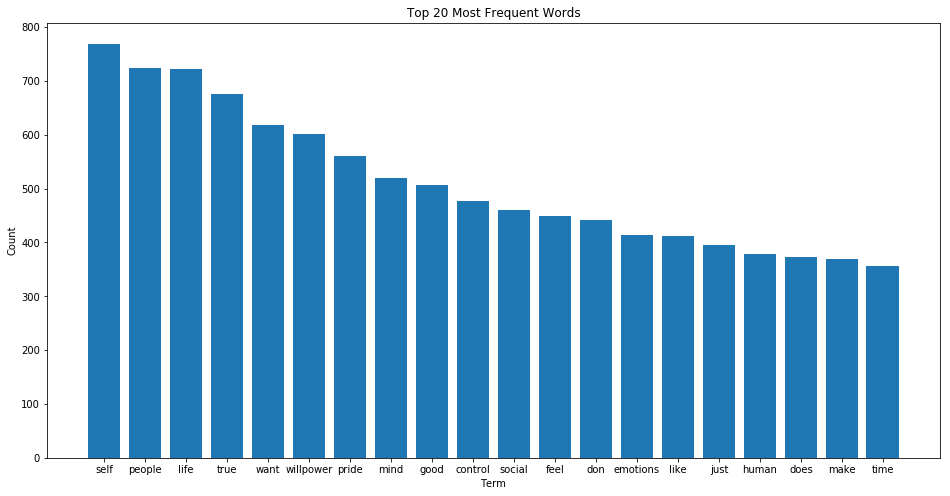

In [3]:
# get word frequencies from the bag of words and sort them by count in descending order
term_frequency = [(term, tf_matrix.sum(axis=0)[0, i]) for term, i in tf_vectorizer.vocabulary_.items()]
term_frequency = sorted(term_frequency, key = lambda x: x[1], reverse=True)
terms = [i[0] for i in term_frequency[:20]] # get top 20 words
count = [i[1] for i in term_frequency[:20]] # get counts of top 20 words

# plot the 20 most frequent words in a bar chart
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(terms)), count)
ax.set_xticks(range(len(terms)))
ax.set_xticklabels(terms)
ax.set_title('Top 20 Most Frequent Words')
ax.set_xlabel('Term')
ax.set_ylabel('Count')
plt.show()

# 4. Clustering (KMeans)

Our main algorithm for clustering will be k-means, which randomly initializes cluster centers, assigns all data points to their closest centroid (measured as least squared Euclidean distance), and then gradually and heuristically moves the centroids until convergence, i.e., until each centroid has become the actual center of its assigned data points (although reaching an optimum is not guaranteed). Note that Scikit-learn's KMeans uses an improved initialization algorithm&mdash;<a href="https://en.wikipedia.org/wiki/K-means%2B%2B#Improved_initialization_algorithm">k-means++</a>&mdash;by default.

In my blog, I manually grouped my posts into four broad topic categories, so we will tell the model to find 4 clusters. After fitting the model with the matrix of vectorized words and storing the centroids, we can peek into the clustering results by printing out the top 3 defining words of each cluster.

In [4]:
k = 4 # number of clusters

# build and fit model, then store centroids
km = KMeans(k)
km_matrix = km.fit_transform(tfidf_matrix)
km_centroids = km.cluster_centers_.argsort()[:, ::-1]

# create a dictionary with the top three words for each cluster
top_words = {}
for i in range(4):
    top_words[i] = ""
    for c in km_centroids[i, :3]:
        if top_words[i] == "":
            top_words[i] = tfidf_words[c]
        else:
            top_words[i] = top_words[i] + ", " + tfidf_words[c]
    print('Cluster %s:' %i, top_words[i])

Cluster 0: moral, meaning, values
Cluster 1: willpower, control, self
Cluster 2: pride, ego, humility
Cluster 3: true, mind, life


The clusters already make sense, but we shall wait until #9 for an in-depth qualitative evaluation.

# 5. Cluster Visualization (MDS, TSNE)

To visualize our clusters in a two-dimensional plot, we can use manifold learning models such as
1. MDS (multi-dimensional scaling), which models dissimilarity data by computing geometric distances, and
2. T-SNE (t-distributed Stochastic Neighbor Embedding), which converts pairwise affinities of data points to probabilities (see <a href="http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf">van der Maaten & Hinton, 2008</a>).

Let's fit both models with and without cosine distance.

Using cosine distance is generally recommended for text data, but as we shall see, the plots look better without it. To build the plots, we create a data frame with x and y coordinates, post titles, and cluster labels before we group it by the latter. For the fun of it, let's also store the figure as a PNG image.

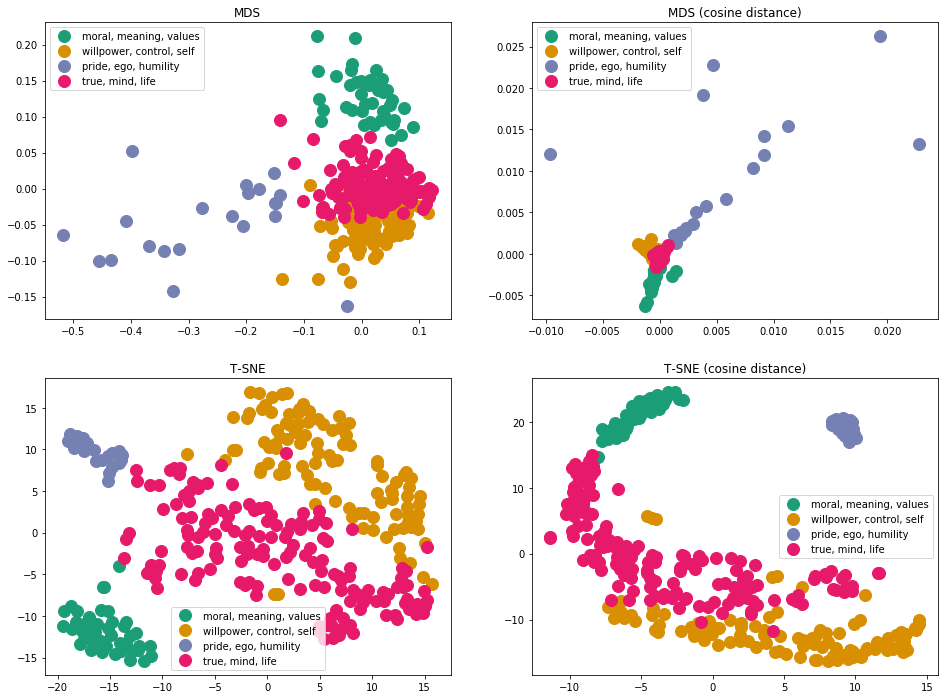

In [5]:
# fit two non-linear dimensionality reduction models
mds = MDS().fit_transform(km_matrix)
tsne = TSNE().fit_transform(km_matrix)

# fit models with cosine distance
cos_dist = 1 - cosine_similarity(km_matrix)
mds_cos = MDS(dissimilarity="precomputed").fit_transform(cos_dist)
tsne_cos = TSNE(metric="cosine").fit_transform(cos_dist)

# create data frame with coordinates, cluster labels, and post titles, grouped by clusters
df = pd.DataFrame(dict(x1=mds[:,0], y1=mds[:,1], x2=mds_cos[:,0], y2=mds_cos[:,1],
                       x3=tsne[:,0], y3=tsne[:,1], x4=tsne_cos[:,0], y4=tsne_cos[:,1],
                       label=km.labels_.tolist(), title=data['post_title']))
groups = df.groupby('label')

# set a color and get the top three words for each cluster
clusters = {0: ('#1b9e77', top_words[0]),
            1: ('#d98f02', top_words[1]),
            2: ('#7580b3', top_words[2]),
            3: ('#e7196a', top_words[3]), }

# build two plots for the manifold learning models
fig, ax = plt.subplots(2,2, figsize=(16,12)) # 2x2 subplots
ax[0,0].set_title('MDS'); ax[0,1].set_title('MDS (cosine distance)') # titles for first row
ax[1,0].set_title('T-SNE'); ax[1,1].set_title('T-SNE (cosine distance)') # titles for second row
for i,g in groups: # iterate over clusters
    ax[0,0].plot(g.x1, g.y1, marker='o', linestyle='', ms=12, color=clusters[i][0], label=clusters[i][1])
    ax[0,1].plot(g.x2, g.y2, marker='o', linestyle='', ms=12, color=clusters[i][0], label=clusters[i][1])
    ax[1,0].plot(g.x3, g.y3, marker='o', linestyle='', ms=12, color=clusters[i][0], label=clusters[i][1])
    ax[1,1].plot(g.x4, g.y4, marker='o', linestyle='', ms=12, color=clusters[i][0], label=clusters[i][1])
ax[0,0].legend(); ax[0,1].legend(); ax[1,0].legend(); ax[1,1].legend() # add legends

# save the figure as png and display it
plt.savefig('clusters.png', dpi=200)
plt.show()

# 6. Cluster Exploration

With the mpld3 library, we can use JavaScript and CSS code to create an interactive map that displays a tooltip with the blog title for each data point when the mouse hovers over it. This is great for exploring how my blog posts were clustered! I must give credit here to Brandon Rose (http://brandonrose.org) for this sweet piece of code&mdash;thank you.

In [6]:
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      this.fig.toolbar.draw();
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}


# define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
  font-size:14px;
  font-weight: bold;
  color: White;
  background-color: DodgerBlue;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -75px;}
"""

# create plot
fig, ax = plt.subplots(figsize=(14,6))
for i,g in groups: # layer the plot by iterating through cluster labels
    points = ax.plot(g.x3, g.y3, marker='o', linestyle='', ms=14, color=clusters[i][0], label=clusters[i][1])
    labels = [i.title() for i in g.title] # get the blog posts titles in title case
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels, voffset=10, hoffset=10, css=css) # set tooltip
    mpld3.plugins.connect(fig, tooltip, TopToolbar()) # connect tooltip to fig
ax.legend(edgecolor='white') # add 

# save as html file and show plot
html = mpld3.fig_to_html(fig)
with open("clusters.html", "w") as file: file.write(html)
mpld3.display()

Being deeply familiar with every data point (as it represents a blog post I have written), I can learn a lot from this interactive plot. But you, too, if you just briefly look at some of the titles and their relative distances, will quickly be able to confirm that the clustering has been very successful: the patterns make sense!

# 7. Predictive Evaluation

To find out the degree to which blog titles and contents belong to the same clusters, we can let the k-means model predict in which cluster each title and content fits best and then compute the overlap of these predictions.

In addition, we can see how the four pairs of topic categories I use on my blog map to the four clusters generated by the model. 100% would mean that the model has categorized my blog posts very similarly to how I have categorized them.

In [7]:
# use model to predict the cluster for each title and content
title_predictions = []
content_predictions = []
for i in range(len(data['post_content'])):
    titles = tfidf_vectorizer.transform([data['post_title'][i]])
    title_predictions.append(km.predict(titles))
    contents = tfidf_vectorizer.transform([data['post_content'][i]])
    content_predictions.append(km.predict(contents))

# check how often a post's title and content are predicted to belong to the same cluster
match = []
for i in range(len(title_predictions)):
    if title_predictions[i] == content_predictions[i]:
        match.append(1)
    else:
        match.append(0)
print('Title/content match: ' + str(round(sum(match)/len(match)*100, 1)) + '%')

# test to what extent each manually defined topic category falls into its own cluster
category_predictions = []
for topic in ('psychology cognitive science', 'willpower self improvement',
            'philosophy spirituality', 'morality ethics'):
    Category = tfidf_vectorizer.transform([topic])
    category_predictions.append(km.predict(Category)[0])  
print('Category similarity: ' + str(len(set(category_predictions))/k*100) + '%')

Title/content match: 74.2%
Category similarity: 75.0%


# 8. More Models (NMF, LSA, LDA)

Now let's look at three additional models, and let's also combine them with k-means:
1. NMF for <a href="https://en.wikipedia.org/wiki/Non-negative_matrix_factorization">non-negative matrix factorization</a> (see <a href="https://smartech.gatech.edu/handle/1853/20058">Kim & Park, 2008</a>)
2. TruncatedSVD for <a href="https://en.wikipedia.org/wiki/Latent_semantic_analysis">Latent Semantic Analysis</a> (LSA)
3. LatentDirichletAllocation for <a href="https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation">Latent Dirichlet Allocation</a> (LDA)
4. NMF→KMeans for NMF-based k-means
5. TruncatedSVD→Kmeans for LSA-based k-means
6. LatentDirichletAllocation→KMeans for LDA-based k-means (see <a href="https://www.semanticscholar.org/paper/K-means-Document-Clustering-Based-on-Latent-Guan/9e623a64d1d3f8f73bfedc855c3b8f6861eea591">Guan, 2016</a> and <a href="https://link.springer.com/chapter/10.1007/978-3-319-54472-4_24">Bui et. al, 2017</a>)

In [8]:
nmf = NMF(k)
nmf_matrix = nmf.fit_transform(tfidf_matrix)

lsa = TruncatedSVD(k)
lsa_matrix = lsa.fit_transform(tfidf_matrix)

lda = LatentDirichletAllocation(k, learning_method='batch')
lda_matrix = lda.fit_transform(tf_matrix)

km_nmf = KMeans(k).fit(nmf_matrix) # NMF-based k-means
km_lsa = KMeans(k).fit(lsa_matrix) # LSA-based k-means
km_lda = KMeans(k).fit(lda_matrix) # LDA-based k-means

# 9. Qualitative Evaluation

For qualitative evaluation, we can look at the three words that were most defining for each cluster produced by a model. If the word combinations make sense, if all top words of a cluster belong to a distinct category, and if there's little topical overlap between clusters, we may judge the model as good.

In [9]:
def top_words_decomp(model_name, model, terms):
    ''' prints the top 3 words of each cluster
        from the components of decomposition models '''
    print(model_name)
    for i, topic in enumerate(model.components_):
        print("Cluster %d: " % (i), end="")
        print(" ".join([terms[t] for t in topic.argsort()[:-4:-1]]))
    print()

top_words_decomp(" ---NMF---", nmf, tfidf_words)
top_words_decomp(" ---LSA---", lsa, tfidf_words)
top_words_decomp(" ---LDA---", lda, tf_words)
    
def top_words_cluster(model_name, centers):
    ''' prints the top 3 words of each cluster
        from the centroids of the k-means models '''
    print(model_name)
    for i in range(k):
        print("Cluster %d: " % i, end="")
        print(" ".join([tfidf_words[c] for c in centers[i, :3]]))
    print()

top_words_cluster(" ---K-M---", km_centroids)
top_words_cluster(" ---NMF-KM---", nmf.inverse_transform(km_nmf.cluster_centers_).argsort()[:, ::-1])
top_words_cluster(" ---LSA-KM---", lsa.inverse_transform(km_lsa.cluster_centers_).argsort()[:, ::-1])

 ---NMF---
Cluster 0: meditation mindfulness life
Cluster 1: moral values meaning
Cluster 2: pride humility ego
Cluster 3: willpower emotions control

 ---LSA---
Cluster 0: pride self true
Cluster 1: moral values meaning
Cluster 2: pride emotion emotions
Cluster 3: emotions willpower control

 ---LDA---
Cluster 0: human social people
Cluster 1: pride willpower self
Cluster 2: life want mind
Cluster 3: people emotions meaning

 ---K-M---
Cluster 0: moral meaning values
Cluster 1: willpower control self
Cluster 2: pride ego humility
Cluster 3: true mind life

 ---NMF-KM---
Cluster 0: willpower emotions control
Cluster 1: life mind meditation
Cluster 2: pride humility true
Cluster 3: moral values meaning

 ---LSA-KM---
Cluster 0: willpower control emotions
Cluster 1: moral values meaning
Cluster 2: pride true humility
Cluster 3: life meditation mindfulness



From what I know about the data, consisting of my own blog posts (hence easy for me to interpret), the NMF clusters are certainly the best. Their top three words neatly outline the very topics I have written about the most on my blog:
- "meditation mindfulness life" ⇨ Philosophy & Spirituality (especially the latter)
- "moral values meaning" ⇨ Morality & Ethics (quite obviously)
- "pride humility ego" ⇨ Psychology & Cognitive Science (especially psychology of pride)
- "willpower emotions control" ⇨ Willpower & Self-Improvement

Here's the full model ranking:
1. NMF is the winner: clear and distinct clusters that match my manually chosen topic categories.
2. NMF-based KMeans and LSA-based KMeans share the second place: they produced almost identical clusters, with only 'mind' vs. 'mindfulness' differing, and even the "pride true humility" cluster makes sense, given that I have written several posts on the notion of 'true pride' (or 'authentic pride' as it's called in psychology and behavioral economics).
3. KMeans takes the third place: it has the same ethics/morality and pride/humility clusters as NMF and a cluster with 'willpower' and 'self-control', but the "true mind life" cluster could be more expressive.
4. LDA performed worse than all the KMeans variations: "human social people" seems to be an ethics cluster, but is not particularly expressive; 'people' occurs twice among the top three words; "pride willpower self" combines two loosely connected topics; "life want mind" could be related to my posts on the True Will, a life philosophy topic; "people emotions meaning" is an unclear cluster and overlaps with the ethics cluster because I have written about 'meaning' mostly in an ethical context.
5. LSA is the loser here: 'self' shouldn't be a top word for the psychology of pride cluster because the 'self' as in 'self-control' and 'self-discipline' is associated with a somewhat different topic; 'pride' shouldn't occur twice and certainly not as the top word of two different clusters; and, of course, we shouldn't have three occurrences of 'emotion(s)'.

Had we used better tokenization and stemmed our tokens, LSA would have performed better. Still, it is worth noting that all other algorithms did quite well even without any stemming prior to the word vectorization.

# 10. Autoencoder

Ready for something more complex?

Autoencoders!

What's that?

Autoencoders are neural networks used for unsupervised learning. They are a powerful tool for dealing with the curse of dimensionality.

Every autoencoder consists of two parts: (1) an encoder with multiple layers to reduce dimensionality and (2) a decoder with multiple layers to reconstruct the input from the dimensionally-reduced data. By reconstructing its inputs, the network detects the most important features in the data as it learns the identity function under the constraint of reduced dimensionality (or added noise). Since clustering is a form of dimensionality reduction, autoencoders should be useful for categorizing my blog posts into four broad topics.

In the code below, we use TensorFlow to build an autoencoder with three layers. First, we set two hyperparameters (learning rate and number of epochs) as well as the network parameters (numbers of nodes for three layers). Then, after defining the graph input (X) and all weights and biases, initialized with normally-distributed random numbers, we build an encoder and a decoder function, both with sigmoid activation functions for each layer. Then we construct the model and define the functions for loss and optimization: minimize squared error! Finally, we initialize the variables and launch the graph before we run the session and training cycles. In the last two lines, we get the results and end the training session.

In [10]:
learning_rate = 0.01
training_epochs = 500

n_input = tfidf_matrix.shape[1]
n_hidden_1 = tfidf_matrix.shape[1] // 2
n_hidden_2 = 4

X = tf.placeholder("float", [None, n_input])

weights = {
    'encoder_h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'encoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'decoder_h1': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_1])),
    'decoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
}

biases = {
    'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'decoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'decoder_b2': tf.Variable(tf.random_normal([n_input])),
}


def encoder(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']), biases['encoder_b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']), biases['encoder_b2']))
    return layer_2

def decoder(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),biases['decoder_b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']), biases['decoder_b2']))
    return layer_2

enc = encoder(X)
dec = decoder(enc)

cost = tf.reduce_mean(tf.pow(X - dec, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

init = tf.global_variables_initializer()
sess = tf.InteractiveSession() # interactive for jupyter notebook
sess.run(init)

for epoch in range(training_epochs):
    for i in range(len(data)): # one batch per blog post
        _, c = sess.run([optimizer, cost], feed_dict={X: tfidf_matrix[i].toarray()})
    if epoch % 20 == 0: # display every twentieth epoch
        print("Epoch:", '%03d' % epoch, "cost =", "{:.9f}".format(c))

autoenc_results = dec.eval(feed_dict={X: tfidf_matrix.toarray()})      
sess.close()

Epoch: 000 cost = 0.202191561
Epoch: 020 cost = 0.116760351
Epoch: 040 cost = 0.093907148
Epoch: 060 cost = 0.084101938
Epoch: 080 cost = 0.066177517
Epoch: 100 cost = 0.050093554
Epoch: 120 cost = 0.039167829
Epoch: 140 cost = 0.032268200
Epoch: 160 cost = 0.028248718
Epoch: 180 cost = 0.020211382
Epoch: 200 cost = 0.018206183
Epoch: 220 cost = 0.015189069
Epoch: 240 cost = 0.014175265
Epoch: 260 cost = 0.011273415
Epoch: 280 cost = 0.008259337
Epoch: 300 cost = 0.008256634
Epoch: 320 cost = 0.006246701
Epoch: 340 cost = 0.006244685
Epoch: 360 cost = 0.005244315
Epoch: 380 cost = 0.004235250
Epoch: 400 cost = 0.002221577
Epoch: 420 cost = 0.002223759
Epoch: 440 cost = 0.001213119
Epoch: 460 cost = 0.001217485
Epoch: 480 cost = 0.001214252


The loss decreased very well, and much better than for all the many other variations and parameters I tried before.

Now, let's feed the results of our NN into a k-means model and plot the clusters.

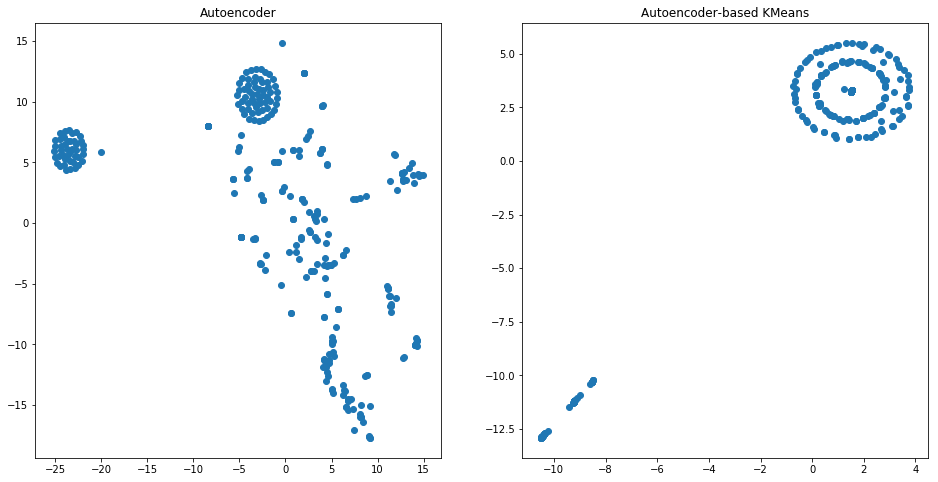

In [11]:
km_autoenc = KMeans(k).fit(autoenc_results) # autoencoder-based k-means

# fit T-SNE with cosine distance of autoencoder and autoencoder-based k-means results
cos_dist_autoenc = 1 - cosine_similarity(autoenc_results)
tsne_autoenc = TSNE(metric="cosine").fit_transform(cos_dist_autoenc)
cos_dist_km_autoenc = 1 - cosine_similarity(KMeans(k).fit_transform(autoenc_results))
tsne_km_autoenc = TSNE(metric="cosine").fit_transform(cos_dist_km_autoenc)

# plot T-SNE results
fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].set_title('Autoencoder')
ax[0].scatter(tsne_autoenc[:,0], tsne_autoenc[:,1])
ax[1].set_title('Autoencoder-based KMeans')
ax[1].scatter(tsne_km_autoenc[:,0], tsne_km_autoenc[:,1])
plt.show()

The autoencoder has found two very distinct topics, and the four autoencoder-based k-means clusters are well-separated. Does this mean that we have a good NLP topic model? We will see in our last and final step: the quantitative evaluation.

# 11. Quantitative Evaluation

For quantitative evaluation, we will use three metrics that don't require ground truth labels:
1. *Silhouette* is a coefficient that measures consistency within clusters; it should be non-negative and the closer to 1 the better.
2. *WCSS* or *inertia* means within-cluster sum-of-squares, which measures cluster compactness; the smaller the better.
3. *Calinski-Harabasz* is an index calculated as the ratio of between-clusters dispertion and within-cluster dispersion, thus measuring both denseness and separateness of clusters; the larger the better.

In this final step, we create an evaluation table with the scores for all our k-means models on these three metrics.

In [12]:
# create evaluation table
evaluation = pd.DataFrame({'Model': ['km', 'km_nmf', 'km_lsa', 'km_lda', 'km_autoenc']})
sc, wcss, chi = [], [], []

# calculate scores
for model in (km, km_nmf, km_lsa, km_lda, km_autoenc):
    sc.append(silhouette_score(tfidf_matrix.toarray(), model.labels_))
    wcss.append(round(model.inertia_, 2))
    chi.append(round(calinski_harabaz_score(tfidf_matrix.toarray(), model.labels_), 2))

# use term frequency matrix for LDA
sc[-2] = silhouette_score(tf_matrix.toarray(), km_lda.labels_)
chi[-2] = round(calinski_harabaz_score(tf_matrix.toarray(), model.labels_), 2)

# fill and display evaluation table
evaluation['Silhouette'] = sc
evaluation['WCSS'] = wcss
evaluation['Calinski-Harabasz'] = chi
evaluation.head()

,Model,Silhouette,WCSS,Calinski-Harabasz
0,km,0.021681,276.53,5.89
1,km_nmf,0.023509,2.37,6.35
2,km_lsa,0.024072,8.69,6.32
3,km_lda,0.019009,23.82,0.67
4,km_autoenc,-0.014269,0.00,1.03


# 12. Conclusion

Although these stats aren't particularly impressive (e.g., all silhouette coefficients are almost zero), their relative values are diagnostic nonetheless:
1. NMF-based KMeans and LSA-based KMeans are the best models: high SC, low WCSS, and high CHI.
2. KMeans alone is not quite as good: worse on all three metrics.
4. LDA-based KMeans and autoencoder-based KMeans are the losers.

This thoroughly confirms the above quantitative analysis.

In conclusion, it appears that sticking to NMF-based KMeans, LSA-based KMeans, or even just NMF alone is the best choice for this data set and our word vectorization method.